# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Predictions with ML Regression Models (T3) - train_features.csv & train_salaries.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [4]:
# Last 5 rows of the dataset
df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


## Prepare Train and Test Sets

In [5]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


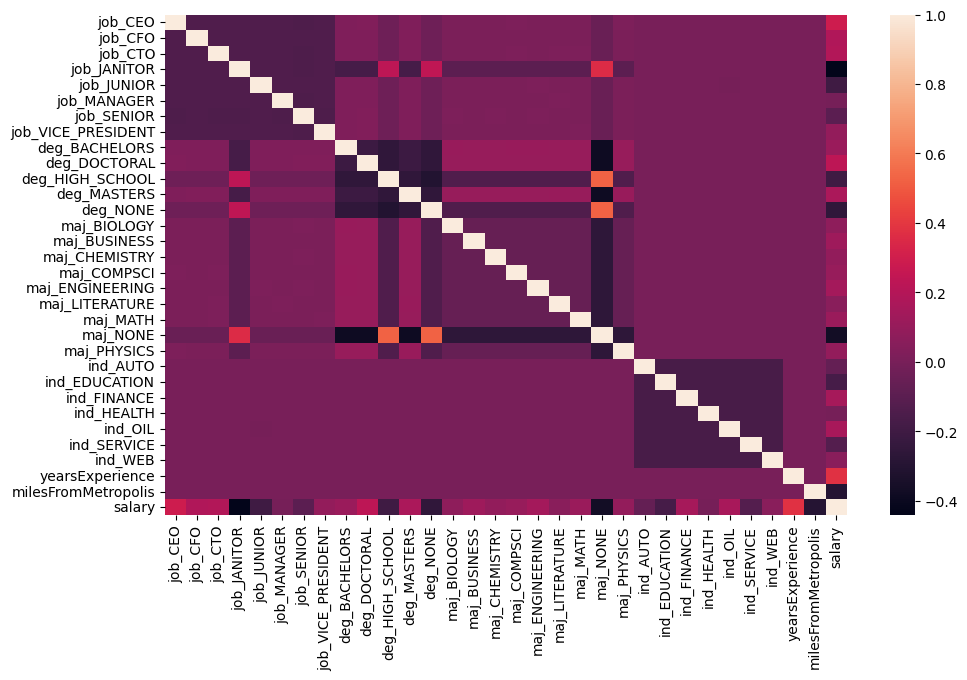

#### CORRELATION VALUES AGAINST SALARIES ####
job_CEO                0.285245
job_CFO                0.188804
job_CTO                0.189600
job_JANITOR           -0.441660
job_JUNIOR            -0.201993
job_MANAGER           -0.006781
job_SENIOR            -0.103642
job_VICE_PRESIDENT     0.090941
deg_BACHELORS          0.111923
deg_DOCTORAL           0.231391
deg_HIGH_SCHOOL       -0.203543
deg_MASTERS            0.171992
deg_NONE              -0.257349
maj_BIOLOGY            0.076341
maj_BUSINESS           0.126124
maj_CHEMISTRY          0.084046
maj_COMPSCI            0.102987
maj_ENGINEERING        0.144176
maj_LITERATURE         0.053920
maj_MATH               0.110401
maj_NONE              -0.371421
maj_PHYSICS            0.092057
ind_AUTO              -0.069913
ind_EDUCATION         -0.175148
ind_FINANCE            0.154847
ind_HEALTH            -0.003439
ind_OIL                0.156959
ind_SERVICE           -0.122361
ind_WEB                0.058949
yearsExperience        0.3

In [6]:
# Show the correlations of all concatenated columns in a heat map
plt.figure(figsize=(11,6.5))
sns.heatmap(df_concat.corr())
plt.show()
print("#### CORRELATION VALUES AGAINST SALARIES ####")
print(df_concat.corr()['salary'])

### Type 3: Use Top 10 Positively Correlated Columns Only

In [7]:
# Use 80% of the dataset as train set, and 20% as test set
# X = df_concat.drop(columns='salary', axis=1)
X = df_concat[['job_CEO','job_CFO','job_CTO','deg_DOCTORAL','deg_MASTERS','maj_BUSINESS','maj_ENGINEERING',
               'ind_FINANCE','ind_OIL','yearsExperience']]
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)
print(X.columns)

TRAIN SIZE: (800000, 10) (800000,)   TEST SIZE: (200000, 10) (200000,)
Index(['job_CEO', 'job_CFO', 'job_CTO', 'deg_DOCTORAL', 'deg_MASTERS',
       'maj_BUSINESS', 'maj_ENGINEERING', 'ind_FINANCE', 'ind_OIL',
       'yearsExperience'],
      dtype='object')


In [8]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [9]:
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [10]:
# Fit the training data into the linear reg. model, then make predictions on the test data
s_time = time.time()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.372 seconds.


In [11]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [40.71521462 30.88517831 30.83623409 23.38741188 18.38844814 12.72131312
 15.73463362 20.48658887 20.65434262  2.00893236]
RANK: 10
INTERCEPT: 64.33032891457697


In [12]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   90.44644958925068 |       73
  123.29161603924594 |      100
  115.11865692593622 |      101
  129.01342969360923 |      112
  129.36735733995903 |      130
  107.80706439468774 |      108
   126.2763242641215 |      130
   82.41072015088953 |       43
  164.59373789266766 |      174
  133.03129441278978 |       88
  106.51790846597297 |      103
  135.93211742895173 |      162
  115.50596857476424 |       73
   99.23337194610474 |       96
  125.34949262077845 |      121
  141.20632600845974 |      187
  151.77367019926749 |      173
   84.98467153208193 |       89
  114.50158043492853 |      106
  101.78026731591689 |      160


In [13]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-linreg.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 741.671713911214
RMSE: 27.233650396361007
MAE: 21.928209182383966
R2 SCORE: 0.5073172984387571
ADJUSTED R2 SCORE: 0.5051486242651424

# CROSS VALIDATION #
FITTING TIME: [0.40256619 0.41760993 0.39141774 0.4499383  0.4182148 ] -> 0.4159493923187256
SCORING TIME: [0.01865029 0.01911449 0.02849507 0.01352    0.01564956] -> 0.01908588409423828
TRAIN SCORE: [0.50534446 0.50497273 0.50546682 0.50477347 0.5052226 ] -> 0.505156015811769
TEST SCORE: [0.50438467 0.50586752 0.50388544 0.50667297 0.50486881] -> 0.5051358808009675


## 2 - Lasso Regression

In [14]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [15]:
# Fit the training data into the lasso model, then make predictions on the test data
s_time = time.time()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.241 seconds.


In [16]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)   

COEF: [28.70272635 18.86113229 18.87456176 17.8739572  12.92870554  0.
  0.         10.70342687 10.87430811  1.99125155]
INTERCEPT: 75.4122874616715
ITERATIONS: 5


In [17]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  101.29855764611611 |       73
  122.16437095632155 |      100
  116.15536885716898 |      101
  129.92324849090423 |      112
  128.12469614515538 |      130
  113.19876018934542 |      108
  107.21555476152109 |      130
   93.33355143551776 |       43
   157.8314989601498 |      174
   133.9057515962034 |       88
   117.2285700673128 |      103
   141.0762819264396 |      162
  105.23375397874707 |       73
    98.2559228554116 |       96
  124.14219303985621 |      121
  139.95754175897173 |      187
  145.03590479274828 |      173
    86.2865955674252 |       89
  107.22500553139666 |      106
  107.22500553139666 |      160


In [18]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-lasso.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 836.3518613424854
RMSE: 28.9197486389921
MAE: 23.233581921508488
R2 SCORE: 0.4444225298427422
ADJUSTED R2 SCORE: 0.44363519140631824

# CROSS VALIDATION #
FITTING TIME: [0.31538653 0.29696393 0.26984382 0.28119826 0.27180552] -> 0.28703961372375486
SCORING TIME: [0.01949525 0.01562691 0.01561904 0.02195334 0.00954676] -> 0.016448259353637695
TRAIN SCORE: [0.44390166 0.44347365 0.44443179 0.44371177 0.44413114] -> 0.44393000241439395
TEST SCORE: [0.4438583  0.4456489  0.44159054 0.44418855 0.44429103] -> 0.4439154652966086


## 3 - Ridge Regression

In [19]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
# Fit the training data into the ridge model, then make predictions on the test data
s_time = time.time()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.118 seconds.


In [21]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [40.71461981 30.88468143 30.83573998 23.38725024 18.38832364 12.72108475
 15.73433628 20.48633814 20.65409095  2.00893237]
INTERCEPT: 64.33067913291562
ITERATIONS: None


In [22]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   90.44679991301211 |       73
  123.29147225586763 |      100
  115.11875559500207 |      101
  129.01352936650608 |      112
  129.36721080928615 |      130
  107.80725305080534 |      108
  126.27582749570013 |      130
    82.4110704422132 |       43
  164.59333179853422 |      174
  133.03139410190553 |       88
  106.51825885460997 |      103
  135.93230619860157 |      162
  115.50585986401865 |       73
    99.2332252937902 |       96
   125.3493460738867 |      121
  141.20608155764177 |      187
  151.77339918025336 |      173
   84.98477007950612 |       89
  114.50154069976715 |      106
  101.78045594770616 |      160


In [23]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-ridge.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 741.6717822046757
RMSE: 27.233651650204305
MAE: 21.92821264875689
R2 SCORE: 0.5073172530723146
ADJUSTED R2 SCORE: 0.5051486151010925

# CROSS VALIDATION #
FITTING TIME: [0.16794419 0.16777515 0.22274613 0.17180753 0.15283298] -> 0.1766211986541748
SCORING TIME: [0.01563478 0.01858115 0.03127623 0.01562428 0.0312655 ] -> 0.022476387023925782
TRAIN SCORE: [0.50534446 0.50497273 0.50546682 0.50477347 0.5052226 ] -> 0.505156015746006
TEST SCORE: [0.50438469 0.50586755 0.5038854  0.50667293 0.50486883] -> 0.5051358810383111


## 4 - Polynomial Regression

In [24]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [25]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(800000, 66) (200000, 66)


### Polynomial Regression with Lasso

In [26]:
lasso = Lasso(max_iter=500)
s_time = time.time()
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 6.461 seconds.


In [27]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)  

COEF: [0.         0.24311129 0.         0.         0.         0.
 0.         0.         0.         0.         0.09278532 0.21818294
 0.         0.         0.         0.         0.         0.
 0.         0.         2.41651012 0.         0.         0.
 0.         0.         0.         0.         0.         1.831818
 0.         0.         0.         0.         0.         0.
 0.         1.83991653 0.         0.         0.         0.
 0.         0.         1.41401086 0.         0.         0.
 0.         0.         1.1076278  0.         0.         0.
 0.         0.6928847  0.         0.         0.         0.8859178
 0.         0.         1.21114368 0.         1.2257138  0.01062985]
INTERCEPT: 93.10937053669528
ITERATIONS: 94


In [28]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 888.2937577701491
RMSE: 29.804257376592176
MAE: 24.01718018254404
R2 SCORE: 0.4099182156344494

# CROSS VALIDATION #
FITTING TIME: [0.33700228 0.32740474 0.32167792 0.329283   0.29272628] -> 0.32161884307861327
SCORING TIME: [0.03153586 0.01938391 0.01561213 0.01559782 0.00506234] -> 0.017438411712646484
TRAIN SCORE: [0.44390166 0.44347365 0.44443179 0.44371177 0.44413114] -> 0.44393000241439395
TEST SCORE: [0.4438583  0.4456489  0.44159054 0.44418855 0.44429103] -> 0.4439154652966086


### Polynomial Regression with Ridge

In [29]:
ridge = Ridge(max_iter=2000)
s_time = time.time()
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.572 seconds.


In [30]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 0.00000000e+00  2.19671298e+01  1.72834090e+01  1.70777008e+01
  1.44122059e+01  1.20115237e+01  9.77575284e+00  1.15587506e+01
  9.80523319e+00  9.77107618e+00  2.00122601e+00  2.19671298e+01
  0.00000000e+00  0.00000000e+00 -8.80847009e+00 -8.51773927e+00
 -3.43682231e+00 -3.30150610e+00 -2.42480638e-01  3.18349579e-01
  2.18105043e-02  1.72834090e+01  0.00000000e+00 -8.39932886e+00
 -8.87615591e+00 -4.03470643e+00 -2.78336189e+00 -1.95825817e-01
 -1.82086188e-02 -1.26240283e-02  1.70777008e+01 -8.39364943e+00
 -8.17297231e+00 -4.11931200e+00 -3.24979276e+00 -3.92709463e-01
 -4.10721588e-01  1.37878823e-02  1.44122059e+01  0.00000000e+00
 -1.53418368e+01 -1.47334173e+01 -1.01387230e+00 -8.28360000e-01
  2.30407910e-03  1.20115237e+01 -1.49528239e+01 -1.51605887e+01
 -1.43921172e+00 -1.44614830e+00 -7.75843686e-04  9.77575284e+00
  0.00000000e+00  1.96583466e+01  9.83313449e+00 -5.19496933e-03
  1.15587506e+01  5.10705247e+00  1.51903579e+01  1.89009944e-02
  9.80523079e+00  0

In [31]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 727.0614881451202
RMSE: 26.96407773585294
MAE: 21.725829414518177
R2 SCORE: 0.5170226780101297

# CROSS VALIDATION #
FITTING TIME: [0.15877485 0.18356752 0.17907071 0.16849923 0.19167209] -> 0.17631688117980956
SCORING TIME: [0.03130555 0.01908922 0.01264262 0.01559973 0.03123641] -> 0.021974706649780275
TRAIN SCORE: [0.50534446 0.50497273 0.50546682 0.50477347 0.5052226 ] -> 0.505156015746006
TEST SCORE: [0.50438469 0.50586755 0.5038854  0.50667293 0.50486883] -> 0.5051358810383111


## 5 - Random Forest Regression

In [32]:
rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=25, min_samples_split=2, 
                                min_samples_leaf=2, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
                                bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None, oob_score=True)
# rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=20, min_samples_split=4, 
#                                 min_samples_leaf=4, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
#                                 bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None)
# rforest = RandomForestRegressor(n_estimators=40)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.2,
 'criterion': 'friedman_mse',
 'max_depth': 25,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Fit the training data into the random forest, then make predictions on the test data
s_time = time.time()
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 7.525 seconds.


In [34]:
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
OOB SCORE: 0.13899138072260364
OOB PREDICTION: [118.1329755  130.93427007  99.92418045 ... 138.21564362 123.91527087
 105.32135599]  800000
FEATURES: 10
OUTPUTS: 1 



In [35]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 1296.986700217549
RMSE: 36.013701562288055
MAE: 28.95764890900337
R2 SCORE: 0.13842890410044772

# CROSS VALIDATION #
FITTING TIME: [7.76397443 7.49747419 7.3780942  9.49802446 7.98668718] -> 8.02485089302063
SCORING TIME: [0.2557447  0.20369792 0.20364332 0.21114373 0.19112754] -> 0.21307144165039063
TRAIN SCORE: [0.1388846  0.13860751 0.13989344 0.13971291 0.13899276] -> 0.13921824394282864
TEST SCORE: [0.13942886 0.14057122 0.13730798 0.1378593  0.14061973] -> 0.13915741841996873


## 6 - Gradient Boosting

In [36]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 37.452 seconds.


In [38]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x209FF6D1340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x209FF6D1340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x209FF6D1340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x209FF6D1340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x209FF6D1340)]]
# OF ESTIMATORS: 100
# OF FEATURES: 10
MAX FEATURES: 10
FEATURE IMPORTANCES: [0.18423246 0.1060138  0.10352594 0.09726071 0.07995095 0.01896101
 0.02317312 0.05502989 0.05731394 0.27453818]
TRAIN SCORE:
[1427.87379648 1367.9568534  1317.9168431  1273.720

In [39]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   91.51590660890166 |       73
  123.43194416868567 |      100
  112.00911630748577 |      101
  126.73611581797319 |      112
  129.52893887001136 |      130
  109.29281034777861 |      108
  115.75422954476032 |      130
   83.96670432623364 |       43
  163.71215304366328 |      174
  129.29053462284287 |       88
  106.40939527416516 |      103
  136.74043971285795 |      162
  110.21637786605342 |       73
  100.47085515897587 |       96
  124.08176126042721 |      121
   142.0501959559012 |      187
  149.68566481045463 |      173
   83.77351050989954 |       89
  110.33617049038331 |      106
  105.26680443130668 |      160


In [40]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 733.0238899451366
RMSE: 27.074413935395473
MAE: 21.81859999758184
R2 SCORE: 0.5130619334225622

# CROSS VALIDATION #
FITTING TIME: [34.88260818 33.76507545 33.3839035  33.5008235  33.42185545] -> 33.79085321426392
SCORING TIME: [0.26910472 0.27787447 0.26282406 0.26549792 0.26533222] -> 0.2681266784667969
TRAIN SCORE: [0.51139585 0.51071024 0.51125984 0.51074745 0.51097901] -> 0.5110184786196941
TEST SCORE: [0.51004839 0.5114917  0.50977627 0.51214117 0.51074979] -> 0.5108414641222724


## 7 - XGBoost

In [41]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
s_time = time.time()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 3.452 seconds.


In [43]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   88.49708557128906 |       73
  126.51819610595703 |      100
  111.97000122070312 |      101
  126.68898010253906 |      112
  130.40232849121094 |      130
  112.50389099121094 |      108
     109.40380859375 |      130
   80.84385681152344 |       43
   163.0631561279297 |      174
  130.38504028320312 |       88
  104.99562072753906 |      103
  138.49148559570312 |      162
  111.22049713134766 |       73
   102.2726058959961 |       96
  127.59893798828125 |      121
   143.2360382080078 |      187
  149.71763610839844 |      173
   81.64080047607422 |       89
  108.06121826171875 |      106
  106.27677917480469 |      160


In [44]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 727.6281593756829
RMSE: 26.974583581135835
MAE: 21.73485150325775
R2 SCORE: 0.5166462458130618

# CROSS VALIDATION #
FITTING TIME: [3.22721744 3.32818127 3.26866651 3.37712765 3.33934569] -> 3.3081077098846436
SCORING TIME: [0.0958209  0.10859847 0.10359812 0.12661529 0.10313082] -> 0.10755271911621093
TRAIN SCORE: [0.51623966 0.51600017 0.5162403  0.51590539 0.51621717] -> 0.5161205386749795
TEST SCORE: [0.51364314 0.51457247 0.51366122 0.51515837 0.51387133] -> 0.5141813059958003


## Results of Metrics of All ML Models Together

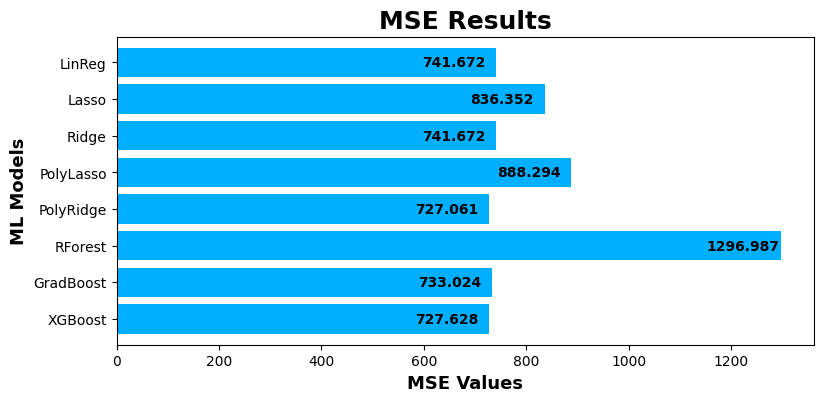

In [45]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'RForest', 'GradBoost', 'XGBoost']
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mse[i]-145, i+0.12, "{:.3f}".format(res_mse[i]), fontweight='bold')
plt.show()

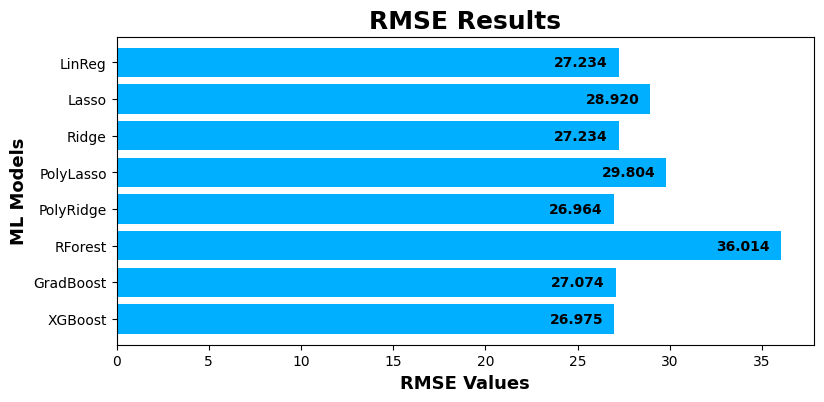

In [46]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_rmse[i]-3.5, i+0.12, "{:.3f}".format(res_rmse[i]), fontweight='bold')
plt.show()

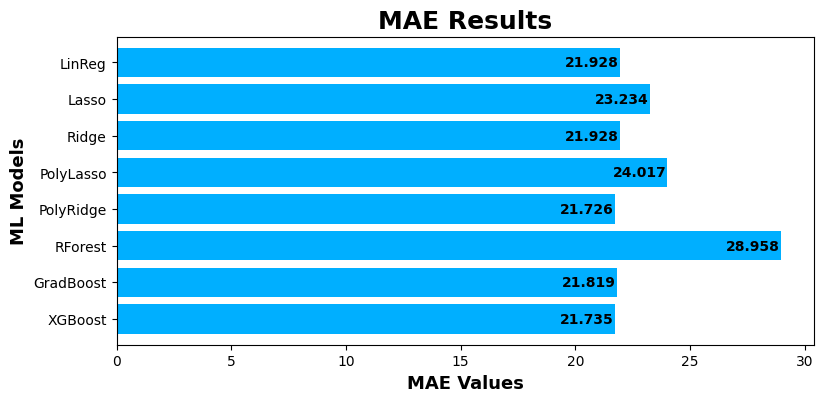

In [47]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mae[i]-2.4, i+0.12, "{:.3f}".format(res_mae[i]), fontweight='bold')
plt.show()

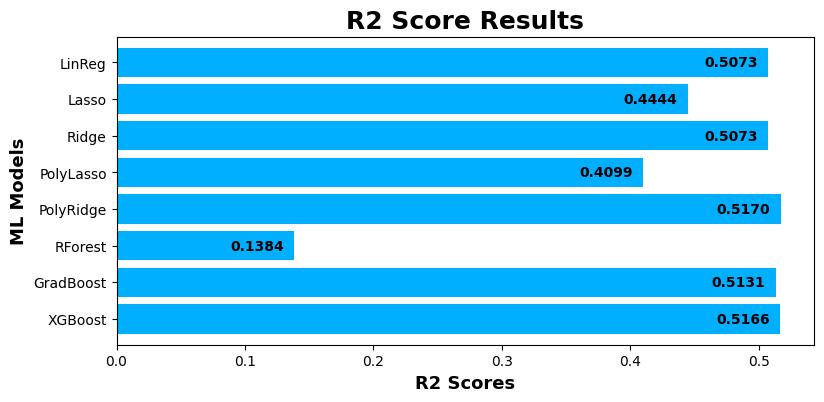

In [48]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_r2[i]-0.05, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

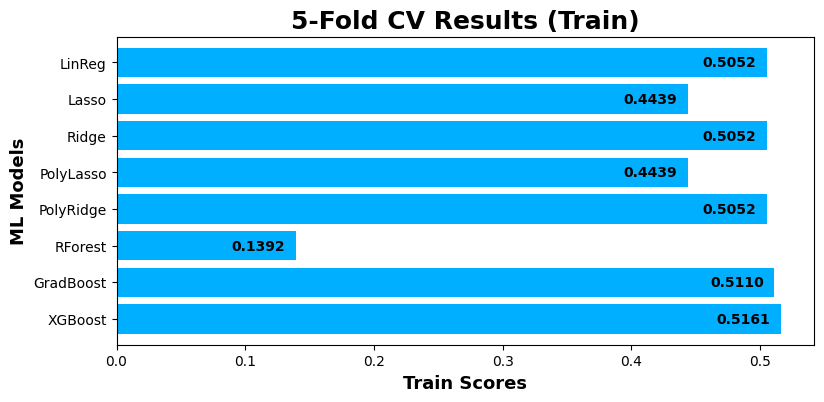

In [49]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_train[i]-0.05, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

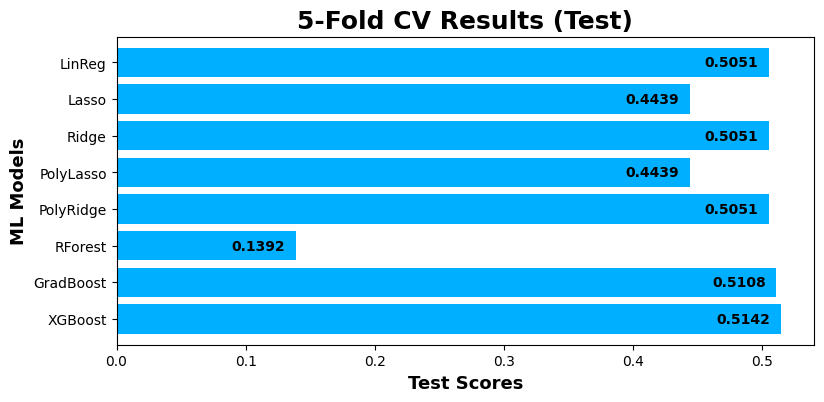

In [50]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_test[i]-0.05, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()